In [0]:
!pip install torch torchvision

In [0]:
# Load zip from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/data_semantics.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  gdrive/My Drive/data_semantics.zip
replace testing/image_2/000000_10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!tar -xvzf gdrive/My\ Drive/iccv09Data.tar.gz

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
DS = 'downsampling'
AS = 'asymetric'
D = 'Dilated'
R = 'regular'

In [0]:
class ENet(nn.Module):
    
    def __init__(self):
        
        self.i_conv = nn.Conv2d(in_channels = 3, 
                                out_channels = 13, 
                                kernel_size = 3,
                                stride = 2,
                                bias = True)
        
        self.i_maxpool = nn.MaxPool2d(kernel_size=2,
                                      stride = None, # and thus stride = 2, which makes it non-overlapping
                                      padding = 0)
        
        
        self.dropout_001 = nn.Dropout2d(p=0.01)
        self.dropout_01 = nn.Dropout2d(p=0.1)
        
        
        
        ########### B 1.0  ####################
        
        self.conv1_1_0, self.prelu1_1_0, self.conv2_1_0, \
        self.prelu2_1_0, self.conv3_1_0, self.maxpool1 = self.bottleneck(stage = 1, 
                                                                         position = 0, 
                                                                       flag = DS)
        
        ########### B 1.1  ####################
        
        self.conv1_1_1, self.prelu1_1_1, self.conv2_1_1, \
        self.prelu2_1_1, self.conv3_1_1 = self.bottleneck(stage = 1, 
                                                          position = 0, 
                                                          flag = R)
        
        ########### B 1.2  ####################
        
        self.conv1_1_2, self.prelu1_1_2, self.conv2_1_2, \
        self.prelu2_1_2, self.conv3_1_2 = self.bottleneck(stage = 1, 
                                                          position = 0, 
                                                          flag = R)
        
        ########### B 1.3  ####################
        
        self.conv1_1_3, self.prelu1_1_3, self.conv2_1_3, \
        self.prelu2_1_3, self.conv3_1_3 = self.bottleneck(stage = 1, 
                                                          position = 0, 
                                                          flag = R)
        
        ########### B 1.4  ####################
        
        self.conv1_1_4, self.prelu1_1_4, self.conv2_1_4, \
        self.prelu2_1_4, self.conv3_1_4 = self.bottleneck(stage = 1, 
                                                          position = 0, 
                                                          flag = R)
        
        self.BatchNorm = nn.BatchNorm2d(num_features = 64)  
        
        #######################################
        
        ########### B 2.0  ####################
        
        self.conv1_2_0, self.prelu1_2_0, self.conv2_2_0, \
        self.prelu2_2_0, self.conv3_2_0, self.maxpool2 = self.bottleneck(stage = 2, 
                                                                         position = 0, 
                                                                         flag = DS)
        
         ########### B 2.1  ####################
        
        self.conv1_2_1, self.prelu1_2_1, self.conv2_2_1, \
        self.prelu2_2_1, self.conv3_2_1 = self.bottleneck(stage = 2, 
                                                          position = 1, 
                                                          flag = R)
        
        ########### B 2.2  ####################
        
        self.conv1_2_2, self.prelu1_2_2, self.conv2_2_1, \
        self.prelu2_2_2, self.conv3_2_2 = self.bottleneck(stage = 2, 
                                                          position = 2, 
                                                          flag = D)
        
        ########### B 2.3  ####################
        
        self.conv1_2_3, self.prelu1_2_3, self.conv2_2_3, self.conv2_2_3 \
        self.prelu2_2_3, self.conv3_2_3 = self.bottleneck(stage = 2, 
                                                          position = 3, 
                                                          flag = AS)
        
        ########### B 2.4  ####################
        
        self.conv1_2_4, self.prelu1_2_3, self.conv2_2_4, \
        self.prelu2_2_4, self.conv3_2_4 = self.bottleneck(stage = 2, 
                                                          position = 4, 
                                                          flag = D)
        
        ########### B 2.5  ####################
        
        self.conv1_2_5, self.prelu1_2_5, self.conv2_2_5, \
        self.prelu2_2_5, self.conv3_2_5 = self.bottleneck(stage = 2, 
                                                          position = 5, 
                                                          flag = R)
        
        ########### B 2.6  ####################
        
        self.conv1_2_6, self.prelu1_2_6, self.conv2_2_6, \
        self.prelu2_2_6, self.conv3_2_6 = self.bottleneck(stage = 2, 
                                                          position = 6, 
                                                          flag = D)
        
        ########### B 2.7  ####################
        
        self.conv1_2_7, self.prelu1_2_7, self.conv2_2_7, self.conv2_2_7_1 \
        self.prelu2_2_7, self.conv3_2_7 = self.bottleneck(stage = 2, 
                                                          position = 7, 
                                                          flag = AS)
        
        ########### B 2.8  ####################
        
        self.conv1_2_8, self.prelu1_2_8, self.conv2_2_8, \
        self.prelu2_2_8, self.conv3_2_8 = self.bottleneck(stage = 2, 
                                                          position = 8, 
                                                          flag = D)
        
        #######################################
        
        
        ########### B 3.0  ####################
        
        ########### B 3.1  ####################
        
        self.conv1_3_1, self.prelu1_3_1, self.conv2_3_1, \
        self.prelu2_3_1, self.conv3_3_1 = self.bottleneck(stage = 3, 
                                                          position = 1, 
                                                          flag = R)
        
        ########### B 3.2  ####################
        
        self.conv1_3_2, self.prelu1_3_2, self.conv2_3_1, \
        self.prelu2_3_2, self.conv3_3_2 = self.bottleneck(stage = 3, 
                                                          position = 2, 
                                                          flag = D)
        
        ########### B 3.3  ####################
        
        self.conv1_3_3, self.prelu1_3_3, self.conv2_3_3, self.conv2_3_3 \
        self.prelu2_3_3, self.conv3_3_3 = self.bottleneck(stage = 2, 
                                                          position = 3, 
                                                          flag = AS)
        
        ########### B 3.4  ####################
        
        self.conv1_3_4, self.prelu1_3_3, self.conv2_3_4, \
        self.prelu2_3_4, self.conv3_3_4 = self.bottleneck(stage = 3, 
                                                          position = 4, 
                                                          flag = D)
        
        ########### B 3.5  ####################
        
        self.conv1_3_5, self.prelu1_3_5, self.conv2_3_5, \
        self.prelu2_3_5, self.conv3_3_5 = self.bottleneck(stage = 3, 
                                                          position = 5, 
                                                          flag = R)
        
        ########### B 3.6  ####################
        
        self.conv1_3_6, self.prelu1_3_6, self.conv2_3_6, \
        self.prelu2_3_6, self.conv3_3_6 = self.bottleneck(stage = 3, 
                                                          position = 6, 
                                                          flag = D)
        
        ########### B 3.7  ####################
        
        self.conv1_3_7, self.prelu1_3_7, self.conv2_3_7, self.conv2_3_7_1 \
        self.prelu2_3_7, self.conv3_3_7 = self.bottleneck(stage = 3, 
                                                          position = 7, 
                                                          flag = AS)
        
        ########### B 3.8  ####################
        
        self.conv1_3_8, self.prelu1_3_8, self.conv2_3_8, \
        self.prelu2_3_8, self.conv3_3_8 = self.bottleneck(stage = 3, 
                                                          position = 8, 
                                                          flag = D)
        
        
        #######################################
        
        
        ########### B 4.0  ####################
        
        self.conv1_3_8, self.prelu1_3_8, self.conv2_3_8, \
        self.prelu2_3_8, self.conv3_3_8 = self.bottleneck(stage = 3, 
                                                          position = 8, 
                                                          flag = U)
        
        ########### B 4.1  ####################
        
        self.conv1_3_8, self.prelu1_3_8, self.conv2_3_8, \
        self.prelu2_3_8, self.conv3_3_8 = self.bottleneck(stage = 3, 
                                                          position = 8, 
                                                          flag = R)
        
        #######################################
        
        ########### B 5.0  ####################
        
        
        #######################################
        
    def forward(self, x):
        
        x_copy = x.clone()
        
        ### Initial Block ###
        x1 = self.i_conv(x)
        x2 = self.i_maxpool(x)
        x = torch.cat((x1, x2), 0)
        
        ### Stage 1 ###
        ## BottleNeck 1.0 ##
        # Main Branch
        x1 = self.maxpool_1_0(x)
        # Side Branch
        x2 = self.conv1_1_0(x)
        x2 = self.batchnorm_1_0(x2)
        x2 = self.prelu1_1_0(x2)
        
        x2 = self.conv2_1_0(x2)
        x2 = self.batchnorm_1_0(x2)
        x2 = self.prelu2_1_0(x2)
        
        x2 = self.conv3_1_0(x2)
        
        x2  = self.dropout_001(x2)
            
        # Concatenate
        x = torch.cat((x1, x2), 0)
        x = self.prelu_1_0(x)
        
        ## BottleNeck 1.1 ##
        
        ### Stage 2 ###
        
    
    def bottleneck(self, stage, position, flag='regular'):
        in_channels = 0
        out_channels = 0
        
        kernel1 = 1
        kernel2 = 3
        kernel3 = 1
        kernel2_1 = (5, 1)
        
        stride1 = 1
        
        prob = 0.1
        
        hw = 64
        
        dilation = 1
        
        
        
        if stage == 1:
            in_channels = 16
            out_channels = 64
            prob = 0.01
            hw = 128
        elif stage == 2:
            in_channels = 64
            out_channels = 128
        elif stage == 3:
            in_channels = 128
            out_channels = 128
        elif stage == 4:
            in_channels = 128
            out_channels = 64
            hw = 128
        elif stage == 5:
            in_channels = 64
            out_channels = 16
            hw = 256
            
        if flag == DS:
            kernel1 = 2
            stride1 = 2
            
        if flag == D:
            if position == 2:
                dilation = 2
            elif position == 4:
                dilation = 4
            elif position == 6:
                dilation = 8
            elif position == 8:
                dilation = 16
                
        if flag == AS:
            kernel2 = (1, 5)
            
        
        # Side branch
        conv1 = nn.Conv2d(in_channels = in_channels,
                       out_channels = out_channels,
                       kernel_size = kernel1,
                       stride = stride1,
                       padding = 0,
                       bias = False)
        
        prelu1 = nn.PReLU()
        
        conv2 = nn.Conv2d(in_channels = out_channels,
                          out_channels = out_channels,
                          kernel_size = kernel2,
                          stride = 1,
                          padding = 1,
                          dilation = dilation,
                          bias = True)
        
        if flag == AS:
            conv2_1 = nn.Conv2d(in_channels = out_channels,
                          out_channels = out_channels,
                          kernel_size = kernel2_1,
                          stride = 1,
                          padding = 1,
                          dilation = dilation,
                          bias = True)
        
        prelu2 = nn.PReLU()
        
        conv3 = nn.Conv2d(in_channels = out_channels,
                          out_channels = out_channels,
                          kernel_size = kernel3,
                          stride = 1,
                          padding = 0,
                          bias = False)
        
        # Main Branch
        
        if (flag == DS):
            max1 = nn.MaxPool2d(kernel_size = 2,
                                  stride = 2,
                                  padding = 0)
            return conv1, prelu1, conv2, prelu2, conv3, max1
        
        try:
            return conv1, prelu1, conv2, conv2_1, prelu2, conv3
        except:
            return conv1, prelu1, conv2, prelu2, conv3
        #extras = torch.zeros((, hw, hw))
        
        return conv1, prelu1, conv2, prelu2, conv3

In [0]:
simg = plt.imread('./training/semantic_rgb/000059_10.png')

In [0]:
def create_mask(img, color_map):
  mask = []
  for i in color_map:
    color_img = []
    for j in range(3):
      color_img.append(np.ones((img.shape[:-1])) * i[j]) 
    
    img2 = np.array(color_img, dtype=np.uint8).transpose(1, 2, 0)
    
    mask.append(np.uint8((img == img2).sum(axis = -1) == 3))
  return np.array(mask)

In [0]:
color_map = [
    (107,142, 35),
    (244, 35,232),
    (0, 0, 142),
    (128, 64,128),
    (0, 0, 0),
    (220, 20, 60),
    (244, 35,232)
]

a = create_mask(simg * 255, color_map)

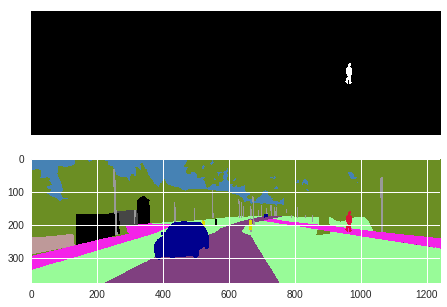

In [0]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.axis('off')
plt.imshow(1 - a[5, :, :])
plt.subplot(2, 1, 2)
plt.imshow(simg)
plt.show()